# 1. Prepare dataset.

Import libraries

In [40]:
import warnings
warnings.filterwarnings("ignore")

import ast
import os
import json
import numpy as np
import pandas as pd
import torch
import importlib
import cv2 

from shutil import copyfile
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from PIL import Image
from string import Template
from IPython.display import display

import torch.nn as nn
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer
import timm

TRAIN_PATH = 'tensorflow-great-barrier-reef'
ROOT_DIR = './'
BASE_DIR = ROOT_DIR + 'fastai'

Load dataset

In [41]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

df = pd.read_csv(f"{TRAIN_PATH}/train.csv")
df.head(5)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


## Prepare dataset

In [42]:
df["num_bbox"] = df['annotations'].apply(lambda x: str.count(x, 'x'))

#Annotations 
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df['bboxes'] = df.annotations.progress_apply(get_bbox)

#Images resolution
df["width"] = 1280
df["height"] = 720

#Path to images
df = df.progress_apply(get_path, axis=1)

# Save only images with annotations
df_train = df[(df.num_bbox) > 0]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

## Split images by tiles and save according to presence of bboxes in them

In [43]:
FOLD_NUM = 5

kf = GroupKFold(n_splits = FOLD_NUM) 
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for f, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
    df_train.loc[val_idx, 'fold'] = f

df_train.groupby('fold').agg({'num_bbox': 'count'})

,num_bbox
fold,
0,1100
1,936
2,968
3,970
4,945


In [44]:
!rm -rf fastai

!mkdir -p fastai/images/train/anns
!mkdir -p fastai/images/train/no_anns

!mkdir -p fastai/images/val/anns
!mkdir -p fastai/images/val/no_anns

In [45]:
import cv2 
from string import Template
from PIL import Image
from IPython.display import display

def calc_intersection(bboxes1, bboxes2):
    assert len(bboxes1) == 4 and len(bboxes2) == 4
    bboxes1 = bboxes1.copy()
    bboxes2 = bboxes2.copy()
    
    x11, y11, x12, y12 = bboxes1[0], bboxes1[1], bboxes1[2], bboxes1[3]
    x21, y21, x22, y22 = bboxes2[0], bboxes2[1], bboxes2[2], bboxes2[3]
    
    x12 += x11
    y12 += y11

    x22 += x21
    y22 += y21
   
    xA = max(x11, x21)
    yA = max(y11, y21)
    xB = min(x12, x22)
    yB = min(y12, y22)

    interArea = max((xB - xA + 1), 0) * max((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)

    iou = interArea / boxBArea
    return iou

# draw the predicitons
def draw_bboxes(img, bboxes):
    for i in range(len(bboxes)):
        box = bboxes[i]
        
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = x0 + int(box[2])
        y1 = y0 + int(box[3])

        cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 1)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def draw_bbox(img, img_bbox, bbox):
    x0 = max(int(bbox[0]) - int(img_bbox[0]), 0)
    y0 = max(int(bbox[1]) - int(img_bbox[1]), 0)
      
    width = int(bbox[2]) + min(int(bbox[0]) - int(img_bbox[0]), 0)
    height = int(bbox[3]) + min(int(bbox[1]) - int(img_bbox[1]), 0)
      
    x1 = min(x0 + width, img_bbox[2])
    y1 = min(y0 + height, img_bbox[3])

    cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 1)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
    return img

fold = 1
width, height = 160, 120
intersect_thr_h = 0.8
intersect_thr_l = 0.05

count_anns = count_no_anns = 0

# split image by tiles 160x120 and if any tile has at least 80% of any bbox in it, than it has annotation, else it hasn't
for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
    if row.fold == fold:
        mode = 'val'
    else:
        mode = 'train'
    
    img_path = row['image_path']
    bboxes = row['bboxes']
    
    img = cv2.imread(img_path)

    # img = draw_bboxes(img, bboxes)
    # display(Image.fromarray(img))

    img_idx = 0
    
    for y in range(0, 720, height):
        for x in range(0, 1280, width):
            cropped_img = img[y : y + height, x : x + width]
            # cropped_img = img.crop((x, y, x+width, y+height))
            img_bbox = [x, y, width, height]
            max_intersect = 0
            for bbox in bboxes:
                intersect = calc_intersection(img_bbox, bbox)
                max_intersect = max(max_intersect, intersect)
                if intersect > intersect_thr_h:
                    count_anns += 1
                    img_path = f'{BASE_DIR}/images/{mode}/anns/{row.image_id}_{img_idx}.jpg'
                    # Draw predictions
                    # out_image = draw_bbox(cropped_img, img_bbox, bbox)
                    # display(Image.fromarray(out_image))
                    cv2.imwrite(img_path, cropped_img)
                    break
            else:
                img_path = f'{BASE_DIR}/images/{mode}/no_anns/{row.image_id}_{img_idx}.jpg'
                if count_anns > count_no_anns/2 and max_intersect < intersect_thr_l:
                    count_no_anns += 1
                    cv2.imwrite(img_path, cropped_img)
            
            img_idx += 1

  0%|          | 0/4919 [00:00<?, ?it/s]

# 2. Create and train model with FastAI and TIMM

Define a timm body of neural network

In [46]:
import timm
import torch.nn as nn
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer


def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    model = timm.create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
    

Define timm with a body and a head

In [47]:
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

Define a timm learner

In [48]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

Prepare dataloader with augmentations

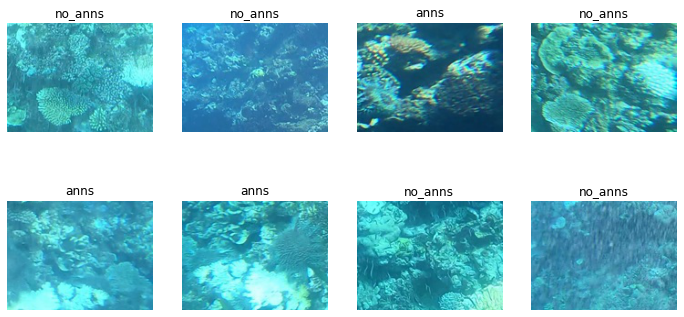

In [49]:
ROOT_DIR = './'
BASE_DIR = ROOT_DIR + 'fastai'
path=Path(BASE_DIR + '/images/')

# transforms
batch_tfms = [Flip(p=0.5), Normalize.from_stats(*imagenet_stats)]#, Brightness(), Contrast()]# , Saturation(), Hue()

def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      get_items=get_image_files,
                      get_y=parent_label,
                      splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                      item_tfms=[Resize(size)],
                      batch_tfms=batch_tfms,
                      )
    return dblock.dataloaders(path, bs=bs)# step 1: use small images for training 

# step 1: use small images for training 
dls = get_dls(64, (120, 160))
dls.train.show_batch(max_n=8, nrows=2)


Create SeNet learner

In [54]:
f'fastai_models/fold{fold}/best.pkl'

'fastai_models/fold1/best.pkl'

In [ ]:
# init learner, save and export model every time when it's valid loss is lower than valid loss of the best model
learn_senet = timm_learner(dls, 'seresnet152d', metrics=[accuracy, error_rate, RocAucBinary()], cbs=SaveModelCallback(min_delta=0.001))
# find optimal lr
lr_min = learn_senet.lr_find()
learn_senet.fit_one_cycle(5, lr_min)
# # step 2: unfreeze model and use large images 
# learn_senet = load_learner(f'fastai_models/fold{fold}/best.pkl')
learn_senet.unfreeze()
learn_senet.dls = get_dls(16, (240, 320))
learn_senet.fit_one_cycle(5, lr_min.valley/10)

epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.371273,0.505529,0.781992,0.218008,0.803229,16:24
1,0.185804,0.408641,0.845445,0.154555,0.885104,16:09
2,0.114985,0.403167,0.867423,0.132577,0.881593,17:10


Better model found at epoch 0 with valid_loss value: 0.5055292248725891.
Better model found at epoch 1 with valid_loss value: 0.4086410403251648.


Export the model

In [39]:
learn_senet.export(f'./fastai_models/fold{fold}/best.pkl')

In [ ]:
# fold = 1
# learn_senet = load_learner(f'fastai_models/fold{fold}/best.pkl')
interp = ClassificationInterpretation.from_learner(learn_senet)
interp.plot_confusion_matrix()

In [ ]:
# Fold 0 (valid loss, accuracy, error rate, ROC AUC) - 0.260939 0.918756 0.081244 0.959949